In [7]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision
import matplotlib.pyplot as plt



folder = ImageFolder('./a5_data_new/train', transform=torchvision.transforms.ToTensor())
loader = DataLoader(folder, batch_size=8, shuffle=True)

# Xexamples, Yexamples = next(iter(loader))

# for i in range(8):
#     plt.subplot(2,4,i+1)  
#     img = Xexamples[i].numpy().transpose(1, 2, 0)    
#     plt.imshow(img, interpolation='none')
#     plt.title('NV' if Yexamples[i] else 'MEL')
#     plt.xticks([])
#     plt.yticks([])
# plt.show()









AttributeError: partially initialized module 'torchvision' has no attribute 'extension' (most likely due to a circular import)

In [ ]:
## making the cnn
import torch
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm

# Check if CUDA is available, otherwise use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

## first we train the model here is the function for training it

# from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torchvision
import numpy

import torch.nn as nn

## lended from lectures evaluates score
def predict_and_evaluate(model, data):

    all_gold = []
    all_pred = []

    for Xbatch, Ybatch in data:
        # move the data to the GPU
        Xbatch = Xbatch.to(device)
        Ybatch = Ybatch.to(device)
        outputs = model(Xbatch)
        predictions = outputs.argmax(dim=1)
        # move the data back to CPU
        # and convert to numpy
        all_gold.extend(Ybatch.cpu().numpy())
        all_pred.extend(predictions.cpu().numpy())



    return accuracy_score(all_gold, all_pred) 

# training function lent from lectures modified to use cuda
def train_classifier(model, train_data, val_data, hyperparams):

    # Deals with model updates. Adam is more effective than SGD.
    optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams['lr'])    
    
    # Cross-entropy loss because we have 10 classes.
    # Note that the softmax is "baked into" this loss, so we should not
    # use a softmax at the end.
    loss_func = torch.nn.CrossEntropyLoss()
      
    # Some statistics.
    acc_history = []

    for epoch in range(hyperparams['n_epochs']):

        # Set the model in training mode, enabling dropout if we use that.
        model.train()
        
        loss_sum = 0

        # For each batch
        for Xbatch, Ybatch in tqdm(train_data):

            # move the data to the GPU
            Xbatch = Xbatch.to(device)
            Ybatch = Ybatch.to(device)

            # Apply the model. We don't know at this point what the model is.
            # The output should be of the shape (batch_size, 10).
            outputs = model(Xbatch)

            # Apply the cross-entropy loss.
            loss = loss_func(outputs, Ybatch)

            # Update the model.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_sum += loss.item()

        # Set the model in evaluation mode. Disables dropout if present.
        model.eval()
        with torch.no_grad():
            # Compute the accuracy on the validation data.
            val_acc = predict_and_evaluate(model, val_data)
                
        mean_loss = loss_sum / len(train_data)

        acc_history.append(val_acc)
        # print the loss and accuracy for this epoch with four decimal points
        print(f'Epoch {epoch+1}: loss = {mean_loss:.4f}, val acc = {val_acc:.4f}')
    
    return acc_history

def train_model(model, trainFolder, testFolder,  epochs=10, batch_size=32, learning_rate=0.001):
  
    train_loader = DataLoader(trainFolder, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(testFolder, batch_size=batch_size, shuffle=False)

    # Define hyperparameters
    hyperparams = {
        'n_epochs': epochs,
        'lr': learning_rate
    }

    # Train the model
    acc_history = train_classifier(model, train_loader, val_loader, hyperparams)

    return acc_history
                

## Import train and test sets from the images. The Y values are the names of the folders
Xtrain = []
Ytrain = []
Xval = []
Yval = []

trainFolder = torchvision.datasets.ImageFolder('./a5_data_new/train', transform=torchvision.transforms.ToTensor())
valFolder = torchvision.datasets.ImageFolder('./a5_data_new/val', transform=torchvision.transforms.ToTensor())



# linear_model = nn.Linear(in_features=n_input_features, out_features=1)
# acc_history = train_model(linear_model, Xtrain, Ytrain, Xval, Yval, epochs=10, batch_size=32, learning_rate=0.001)


# Define the PyTorch model
cnn_model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=5),  # Adjusted input channels to 3 for RGB images
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(16 * 29 * 29, 50),  # Adjusted input size based on image dimensions after convolutions
    nn.ReLU(),
    nn.Linear(50, 10),
).to(device)



# Set hyperparameters for grid search
grid_params = {
    'batch_size': [ 32, 64],
    'learning_rate': [0.001, 0.01]
}

# Perform grid search manually
best_score = 0
best_params = {}

for batch_size in grid_params['batch_size']:
    for learning_rate in grid_params['learning_rate']:
        print(f"Training with batch_size={batch_size}, learning_rate={learning_rate}")
        acc_history = train_model(cnn_model, trainFolder, valFolder, epochs=5 , batch_size=batch_size, learning_rate=learning_rate)
        val_acc = acc_history[-1]  # Get the validation accuracy of the last epoch
        if val_acc > best_score:
            best_score = val_acc
            best_params = {'batch_size': batch_size, 'learning_rate': learning_rate}

print("Best parameters found: ", best_params)
print("Best validation accuracy: ", best_score)

# Train the model with the best parameters
best_batch_size = best_params['batch_size']
best_learning_rate = best_params['learning_rate']
acc_history = train_model(cnn_model, trainFolder, valFolder, epochs=50, batch_size=best_batch_size, learning_rate=best_learning_rate)



Training with batch_size=32, learning_rate=0.001


100%|██████████| 201/201 [00:10<00:00, 19.41it/s]


Epoch 1: loss = 0.5506, val acc = 0.7300


100%|██████████| 201/201 [00:09<00:00, 20.68it/s]


Epoch 2: loss = 0.4639, val acc = 0.7388


100%|██████████| 201/201 [00:09<00:00, 21.18it/s]


Epoch 3: loss = 0.4409, val acc = 0.7971


100%|██████████| 201/201 [00:09<00:00, 21.11it/s]


Epoch 4: loss = 0.4070, val acc = 0.8019


100%|██████████| 201/201 [00:09<00:00, 21.76it/s]


Epoch 5: loss = 0.3989, val acc = 0.7412
Training with batch_size=32, learning_rate=0.01


100%|██████████| 201/201 [00:09<00:00, 21.43it/s]


Epoch 1: loss = 0.8829, val acc = 0.6661


100%|██████████| 201/201 [00:09<00:00, 21.16it/s]


Epoch 2: loss = 0.5803, val acc = 0.6661


100%|██████████| 201/201 [00:09<00:00, 21.57it/s]


Epoch 3: loss = 0.5675, val acc = 0.6677


100%|██████████| 201/201 [00:09<00:00, 20.56it/s]


Epoch 4: loss = 0.6449, val acc = 0.6518


100%|██████████| 201/201 [00:09<00:00, 21.00it/s]


Epoch 5: loss = 0.5916, val acc = 0.6653
Training with batch_size=64, learning_rate=0.001


100%|██████████| 101/101 [00:08<00:00, 11.22it/s]


Epoch 1: loss = 0.5786, val acc = 0.6685


100%|██████████| 101/101 [00:09<00:00, 10.77it/s]


Epoch 2: loss = 0.5742, val acc = 0.6685


100%|██████████| 101/101 [00:08<00:00, 11.31it/s]


Epoch 3: loss = 0.5714, val acc = 0.6693


100%|██████████| 101/101 [00:09<00:00, 11.21it/s]


Epoch 4: loss = 0.5691, val acc = 0.6693


100%|██████████| 101/101 [00:08<00:00, 11.40it/s]


Epoch 5: loss = 0.5687, val acc = 0.6685
Training with batch_size=64, learning_rate=0.01


100%|██████████| 101/101 [00:09<00:00, 11.03it/s]


Epoch 1: loss = 0.5818, val acc = 0.6701


100%|██████████| 101/101 [00:08<00:00, 11.24it/s]


Epoch 2: loss = 0.5785, val acc = 0.6669


100%|██████████| 101/101 [00:09<00:00, 11.09it/s]


Epoch 3: loss = 0.5705, val acc = 0.6917


100%|██████████| 101/101 [00:08<00:00, 11.37it/s]


Epoch 4: loss = 0.5884, val acc = 0.6741


100%|██████████| 101/101 [00:08<00:00, 11.27it/s]


Epoch 5: loss = 0.5752, val acc = 0.6741
Best parameters found:  {'batch_size': 32, 'learning_rate': 0.001}
Best validation accuracy:  0.7412140575079872


100%|██████████| 201/201 [00:09<00:00, 21.44it/s]


Epoch 1: loss = 0.5646, val acc = 0.6989


100%|██████████| 201/201 [00:09<00:00, 21.26it/s]


Epoch 2: loss = 0.5460, val acc = 0.7220


100%|██████████| 201/201 [00:09<00:00, 21.36it/s]


Epoch 3: loss = 0.5288, val acc = 0.7284


100%|██████████| 201/201 [00:09<00:00, 21.61it/s]


Epoch 4: loss = 0.5016, val acc = 0.7660


100%|██████████| 201/201 [00:09<00:00, 21.33it/s]


Epoch 5: loss = 0.4589, val acc = 0.7812


100%|██████████| 201/201 [00:09<00:00, 20.96it/s]


Epoch 6: loss = 0.4089, val acc = 0.7883


100%|██████████| 201/201 [00:09<00:00, 21.83it/s]


Epoch 7: loss = 0.3811, val acc = 0.7971


100%|██████████| 201/201 [00:09<00:00, 21.29it/s]


Epoch 8: loss = 0.3530, val acc = 0.7931


100%|██████████| 201/201 [00:09<00:00, 21.27it/s]


Epoch 9: loss = 0.3223, val acc = 0.7883


100%|██████████| 201/201 [00:09<00:00, 21.27it/s]


Epoch 10: loss = 0.2974, val acc = 0.7843


100%|██████████| 201/201 [00:09<00:00, 21.30it/s]


Epoch 11: loss = 0.2727, val acc = 0.7827


100%|██████████| 201/201 [00:09<00:00, 21.27it/s]


Epoch 12: loss = 0.2469, val acc = 0.7796


100%|██████████| 201/201 [00:09<00:00, 21.21it/s]


Epoch 13: loss = 0.2157, val acc = 0.7851


100%|██████████| 201/201 [00:09<00:00, 21.47it/s]


Epoch 14: loss = 0.1872, val acc = 0.7764


100%|██████████| 201/201 [00:09<00:00, 21.06it/s]


Epoch 15: loss = 0.1621, val acc = 0.7764


100%|██████████| 201/201 [00:09<00:00, 21.60it/s]


Epoch 16: loss = 0.1361, val acc = 0.7652


100%|██████████| 201/201 [00:09<00:00, 21.16it/s]


Epoch 17: loss = 0.1130, val acc = 0.7724


100%|██████████| 201/201 [00:09<00:00, 21.29it/s]


Epoch 18: loss = 0.0949, val acc = 0.7636


100%|██████████| 201/201 [00:09<00:00, 21.36it/s]


Epoch 19: loss = 0.0810, val acc = 0.7620


100%|██████████| 201/201 [00:09<00:00, 21.57it/s]


Epoch 20: loss = 0.0682, val acc = 0.7588


100%|██████████| 201/201 [00:09<00:00, 21.34it/s]


Epoch 21: loss = 0.0504, val acc = 0.7668


100%|██████████| 201/201 [00:09<00:00, 21.47it/s]


Epoch 22: loss = 0.0419, val acc = 0.7644


100%|██████████| 201/201 [00:09<00:00, 21.18it/s]


Epoch 23: loss = 0.0410, val acc = 0.7612


100%|██████████| 201/201 [00:09<00:00, 21.43it/s]


Epoch 24: loss = 0.0362, val acc = 0.7684


100%|██████████| 201/201 [00:09<00:00, 21.46it/s]


Epoch 25: loss = 0.0277, val acc = 0.7652


100%|██████████| 201/201 [00:09<00:00, 21.21it/s]


Epoch 26: loss = 0.0192, val acc = 0.7676


100%|██████████| 201/201 [00:09<00:00, 21.69it/s]


Epoch 27: loss = 0.0157, val acc = 0.7692


100%|██████████| 201/201 [00:09<00:00, 20.93it/s]


Epoch 28: loss = 0.0192, val acc = 0.7724


100%|██████████| 201/201 [00:10<00:00, 18.79it/s]


Epoch 29: loss = 0.0184, val acc = 0.7716


100%|██████████| 201/201 [00:09<00:00, 20.88it/s]


Epoch 30: loss = 0.0196, val acc = 0.7588


100%|██████████| 201/201 [00:09<00:00, 21.19it/s]


Epoch 31: loss = 0.0347, val acc = 0.7732


100%|██████████| 201/201 [00:09<00:00, 21.35it/s]


Epoch 32: loss = 0.0155, val acc = 0.7660


100%|██████████| 201/201 [00:09<00:00, 21.60it/s]


Epoch 33: loss = 0.0084, val acc = 0.7668


100%|██████████| 201/201 [00:09<00:00, 21.23it/s]


Epoch 34: loss = 0.0070, val acc = 0.7668


100%|██████████| 201/201 [00:09<00:00, 20.90it/s]


Epoch 35: loss = 0.0066, val acc = 0.7628


100%|██████████| 201/201 [00:09<00:00, 21.27it/s]


Epoch 36: loss = 0.0067, val acc = 0.7660


100%|██████████| 201/201 [00:08<00:00, 24.64it/s]


Epoch 37: loss = 0.0503, val acc = 0.7612


100%|██████████| 201/201 [00:09<00:00, 21.36it/s]


Epoch 38: loss = 0.0262, val acc = 0.7764


100%|██████████| 201/201 [00:09<00:00, 21.41it/s]


Epoch 39: loss = 0.0098, val acc = 0.7684


100%|██████████| 201/201 [00:09<00:00, 21.31it/s]


Epoch 40: loss = 0.0244, val acc = 0.7700


100%|██████████| 201/201 [00:09<00:00, 21.52it/s]


Epoch 41: loss = 0.0098, val acc = 0.7628


100%|██████████| 201/201 [00:09<00:00, 21.48it/s]


Epoch 42: loss = 0.0053, val acc = 0.7676


100%|██████████| 201/201 [00:09<00:00, 21.35it/s]


Epoch 43: loss = 0.0042, val acc = 0.7684


100%|██████████| 201/201 [00:09<00:00, 21.07it/s]


Epoch 44: loss = 0.0034, val acc = 0.7660


100%|██████████| 201/201 [00:09<00:00, 21.00it/s]


Epoch 45: loss = 0.0028, val acc = 0.7684


100%|██████████| 201/201 [00:09<00:00, 21.22it/s]


Epoch 46: loss = 0.0024, val acc = 0.7692


100%|██████████| 201/201 [00:09<00:00, 21.85it/s]


Epoch 47: loss = 0.0023, val acc = 0.7692


100%|██████████| 201/201 [00:09<00:00, 21.42it/s]


Epoch 48: loss = 0.0021, val acc = 0.7668


100%|██████████| 201/201 [00:09<00:00, 21.44it/s]


Epoch 49: loss = 0.0015, val acc = 0.7708


100%|██████████| 201/201 [00:09<00:00, 21.36it/s]


Epoch 50: loss = 0.0061, val acc = 0.7732


The optimal amount of epochs seems to be around epoch 7 for this dataset.

Now, lets explore the possibilities of normalization. 

In [ ]:



# The model but now with batch normalization
cnn_model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=5),  # Adjusted input channels to 3 for RGB images
    nn.BatchNorm2d(16),  # batch normalization after the first convolution
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=5),
    nn.BatchNorm2d(16),  # batch normalization after the second convolution
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(16 * 29 * 29, 50),  # Adjusted input size based on image dimensions after convolutions
    nn.BatchNorm1d(50),  # batch normalization after the first linear layer
    nn.ReLU(),
    nn.Linear(50, 10),
).to(device)

print("Training with batch normalization")
## we retrain the model using the best parameters and to seven epochs
train_model(cnn_model, trainFolder, valFolder, epochs=7, batch_size=best_batch_size, learning_rate=best_learning_rate)

## lets try to see if we can get a better model by using dropout instead of batch normalization

cnn_model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=5),  # Adjusted input channels to 3 for RGB images
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(16 * 29 * 29, 50),  # Adjusted input size based on image dimensions after convolutions
    nn.Dropout(p=0.5),  # dropout after the first linear layer
    nn.ReLU(),
    nn.Linear(50, 10),
).to(device)
print("Training with dropout")
train_model(cnn_model, trainFolder, valFolder, epochs=7, batch_size=best_batch_size, learning_rate=best_learning_rate)

# lastly we try using layer normalization
cnn_model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=5),  # Adjusted input channels to 3 for RGB images
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(16 * 29 * 29, 50),  # Adjusted input size based on image dimensions after convolutions
    nn.LayerNorm(50),  # layer normalization after the first linear layer
    nn.ReLU(),
    nn.Linear(50, 10),
).to(device)
print("Training with layer normalization")
train_model(cnn_model, trainFolder, valFolder, epochs=7, batch_size=best_batch_size, learning_rate=best_learning_rate)

## and then all together
cnn_model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=5),  # Adjusted input channels to 3 for RGB images
    nn.BatchNorm2d(16),  # batch normalization after the first convolution
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=5),
    nn.BatchNorm2d(16),  # batch normalization after the second convolution
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(16 * 29 * 29, 50),  # Adjusted input size based on image dimensions after convolutions
    nn.LayerNorm(50),  # layer normalization after the first linear layer
    nn.Dropout(p=0.5),  # dropout after the first linear layer
    nn.ReLU(),
    nn.Linear(50, 10),
).to(device)
print("Training with all together")
train_model(cnn_model, trainFolder, valFolder, epochs=7, batch_size=best_batch_size, learning_rate=best_learning_rate)

Training with batch normalization


100%|██████████| 201/201 [00:09<00:00, 21.76it/s]


Epoch 1: loss = 0.7422, val acc = 0.7867


100%|██████████| 201/201 [00:09<00:00, 21.02it/s]


Epoch 2: loss = 0.4197, val acc = 0.8035


100%|██████████| 201/201 [00:09<00:00, 21.18it/s]


Epoch 3: loss = 0.3853, val acc = 0.7364


100%|██████████| 201/201 [00:09<00:00, 21.19it/s]


Epoch 4: loss = 0.3655, val acc = 0.8099


100%|██████████| 201/201 [00:09<00:00, 20.69it/s]


Epoch 5: loss = 0.3455, val acc = 0.7891


100%|██████████| 201/201 [00:09<00:00, 21.02it/s]


Epoch 6: loss = 0.3291, val acc = 0.7332


100%|██████████| 201/201 [00:09<00:00, 21.37it/s]


Epoch 7: loss = 0.3055, val acc = 0.7987
Training with dropout


100%|██████████| 201/201 [00:09<00:00, 21.63it/s]


Epoch 1: loss = 0.6397, val acc = 0.7236


100%|██████████| 201/201 [00:09<00:00, 21.58it/s]


Epoch 2: loss = 0.5136, val acc = 0.7580


100%|██████████| 201/201 [00:09<00:00, 21.10it/s]


Epoch 3: loss = 0.4786, val acc = 0.7620


100%|██████████| 201/201 [00:09<00:00, 21.29it/s]


Epoch 4: loss = 0.4593, val acc = 0.7883


100%|██████████| 201/201 [00:09<00:00, 21.46it/s]


Epoch 5: loss = 0.4635, val acc = 0.7436


100%|██████████| 201/201 [00:09<00:00, 21.19it/s]


Epoch 6: loss = 0.4508, val acc = 0.7580


100%|██████████| 201/201 [00:09<00:00, 20.83it/s]


Epoch 7: loss = 0.4372, val acc = 0.7780
Training with layer normalization


100%|██████████| 201/201 [00:09<00:00, 21.30it/s]


Epoch 1: loss = 0.7253, val acc = 0.6997


100%|██████████| 201/201 [00:09<00:00, 21.89it/s]


Epoch 2: loss = 0.5233, val acc = 0.7173


100%|██████████| 201/201 [00:09<00:00, 21.38it/s]


Epoch 3: loss = 0.4715, val acc = 0.7652


100%|██████████| 201/201 [00:09<00:00, 21.35it/s]


Epoch 4: loss = 0.4422, val acc = 0.7740


100%|██████████| 201/201 [00:09<00:00, 21.20it/s]


Epoch 5: loss = 0.4182, val acc = 0.7835


100%|██████████| 201/201 [00:09<00:00, 21.48it/s]


Epoch 6: loss = 0.4103, val acc = 0.7764


100%|██████████| 201/201 [00:09<00:00, 21.51it/s]


Epoch 7: loss = 0.3924, val acc = 0.7891
Training with all together


100%|██████████| 201/201 [00:09<00:00, 21.32it/s]


Epoch 1: loss = 0.7071, val acc = 0.7260


100%|██████████| 201/201 [00:09<00:00, 21.33it/s]


Epoch 2: loss = 0.4677, val acc = 0.6621


100%|██████████| 201/201 [00:09<00:00, 21.09it/s]


Epoch 3: loss = 0.4332, val acc = 0.6022


100%|██████████| 201/201 [00:09<00:00, 21.64it/s]


Epoch 4: loss = 0.4105, val acc = 0.7788


100%|██████████| 201/201 [00:09<00:00, 21.02it/s]


Epoch 5: loss = 0.3914, val acc = 0.7979


100%|██████████| 201/201 [00:09<00:00, 20.96it/s]


Epoch 6: loss = 0.3860, val acc = 0.7149


100%|██████████| 201/201 [00:09<00:00, 21.10it/s]


Epoch 7: loss = 0.3759, val acc = 0.8003


[0.7260383386581469,
 0.6621405750798722,
 0.6022364217252396,
 0.7787539936102237,
 0.797923322683706,
 0.7148562300319489,
 0.8003194888178914]

It seems the normalisation does a little bit better than the non-normalised data however the difference is not that significant. Batch normalisation seems to be the best option for this dataset. It also seesm that normalisation increases the accuracy per loss in any epoch. This trend can be seen below.

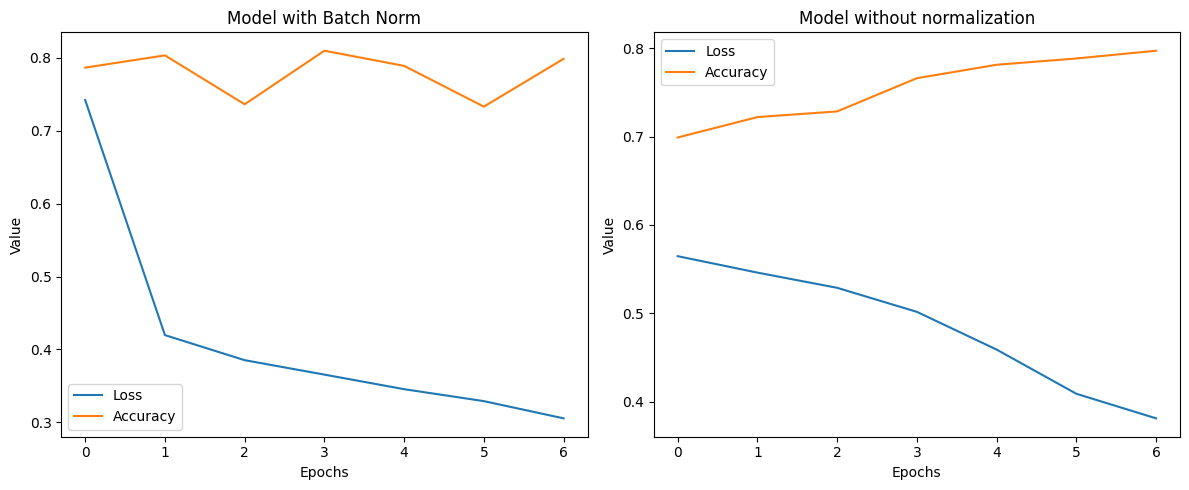

In [12]:
# collected loss and accuracy values for the different models
lossAndAccNorm = [
    (0.7422, 0.7867),
    (0.4197, 0.8035),
    (0.3853, 0.7364),
    (0.3655, 0.8099),
    (0.3455, 0.7891),
    (0.3291, 0.7332),
    (0.3055, 0.7987)
]

lossAndAccReg = [
    (0.5646, 0.6989),
    (0.5460, 0.7220),
    (0.5288, 0.7284),
    (0.5016, 0.7660),
    (0.4589, 0.7812),
    (0.4089, 0.7883),
    (0.3811, 0.7971)
]
# plot them as two graphs where accuracy and loss is over the epochs so accuracy and loss of model one is in graph one 
# and accuracy and loss of model two is in graph two
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot([i[0] for i in lossAndAccNorm], label='Loss')
plt.plot([i[1] for i in lossAndAccNorm], label='Accuracy')
plt.title('Model with Batch Norm')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot([i[0] for i in lossAndAccReg], label='Loss')
plt.plot([i[1] for i in lossAndAccReg], label='Accuracy')
plt.title('Model without normalization')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()


It is also noted that the accuracy is more stable with normalisation. This is likely due to the fact that the model is not as sensitive to the scale of the data.

Lets see if there are any effects using other optimisation techniques such as residual connections, randomly transforming the data, or using a pre-trained model.

In [22]:
## lets add residual connections to the model

# the residual block 
# this is a simple residual block with two convolutions and a skip connection
# it takes the input and passes it through two convolutions with batch normalization and relu activation
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.skip_connection = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)

    def forward(self, x):
        identity = self.skip_connection(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

cnn_model = nn.Sequential(
    ResidualBlock(3, 16, kernel_size=5, stride=1, padding=2),  # a res block with batch normalization
    nn.MaxPool2d(2),
    ResidualBlock(16, 16, kernel_size=5, stride=1, padding=2),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(16 * 32 * 32, 50),  # Adjusted input size based on image dimensions after convolutions
    nn.BatchNorm1d(50),  # batch normalization after the first linear layer
    nn.ReLU(),
    nn.Linear(50, 10),
).to(device)
print("Training with residual connections")
train_model(cnn_model, trainFolder, valFolder, epochs=7, batch_size=best_batch_size, learning_rate=best_learning_rate)



Training with residual connections


  0%|          | 0/201 [00:00<?, ?it/s]

100%|██████████| 201/201 [00:11<00:00, 17.79it/s]


Epoch 1: loss = 0.7169, val acc = 0.7676


100%|██████████| 201/201 [00:11<00:00, 18.26it/s]


Epoch 2: loss = 0.4166, val acc = 0.8163


100%|██████████| 201/201 [00:11<00:00, 18.24it/s]


Epoch 3: loss = 0.3770, val acc = 0.8027


100%|██████████| 201/201 [00:10<00:00, 18.28it/s]


Epoch 4: loss = 0.3550, val acc = 0.7891


100%|██████████| 201/201 [00:11<00:00, 17.80it/s]


Epoch 5: loss = 0.3289, val acc = 0.8291


100%|██████████| 201/201 [00:11<00:00, 18.00it/s]


Epoch 6: loss = 0.2978, val acc = 0.7851


100%|██████████| 201/201 [00:10<00:00, 18.29it/s]


Epoch 7: loss = 0.2636, val acc = 0.7955


[0.7675718849840255,
 0.8162939297124601,
 0.8027156549520766,
 0.7891373801916933,
 0.829073482428115,
 0.7851437699680511,
 0.7955271565495208]

THis added maybe .02 accuracy which is something however training times have reduced from 20 to 18 iterations per second. This is a significant increase in training time.  Still it seems worth it at the moment. Loss also seems to be dropping more significantly.

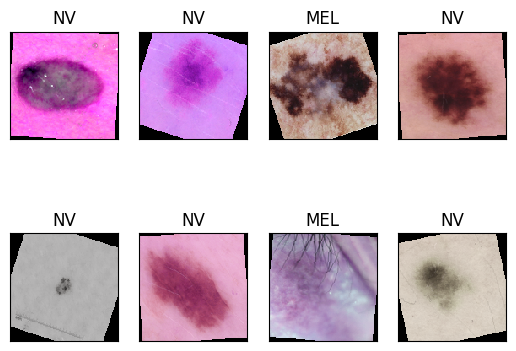

100%|██████████| 201/201 [00:20<00:00,  9.71it/s]


Epoch 1: loss = 0.3600, val acc = 0.8275


100%|██████████| 201/201 [00:20<00:00,  9.90it/s]


Epoch 2: loss = 0.3892, val acc = 0.8051


100%|██████████| 201/201 [00:20<00:00,  9.89it/s]


Epoch 3: loss = 0.3755, val acc = 0.7740


100%|██████████| 201/201 [00:19<00:00, 10.06it/s]


Epoch 4: loss = 0.3650, val acc = 0.8099


100%|██████████| 201/201 [00:18<00:00, 10.60it/s]


Epoch 5: loss = 0.3602, val acc = 0.8315


100%|██████████| 201/201 [00:18<00:00, 10.68it/s]


Epoch 6: loss = 0.3447, val acc = 0.7796


100%|██████████| 201/201 [00:18<00:00, 10.69it/s]


Epoch 7: loss = 0.3459, val acc = 0.8051


[0.8274760383386581,
 0.805111821086262,
 0.7739616613418531,
 0.8099041533546326,
 0.8314696485623003,
 0.7795527156549521,
 0.805111821086262]

In [34]:
cnn_model = nn.Sequential(
    ResidualBlock(3, 16, kernel_size=5, stride=1, padding=2),  # a res block with batch normalization
    nn.MaxPool2d(2),
    ResidualBlock(16, 16, kernel_size=5, stride=1, padding=2),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(16 * 32 * 32, 50),  # Adjusted input size based on image dimensions after convolutions
    nn.BatchNorm1d(50),  # batch normalization after the first linear layer
    nn.ReLU(),
    nn.Linear(50, 10),
).to(device)

# lets try bettering the data by randomly transforming it
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torchvision
import numpy as np
import random
import os

# Set the random seed for reproducibility
random.seed(69)
np.random.seed(69)
os.environ['PYTHONHASHSEED'] = str(69)
torch.manual_seed(69)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(69)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
# the transformations
transform = transforms.Compose([
    # size and shape are important for most skin lesions
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0, saturation=1, hue=0.2),
      # since colors a are fairly uniform for most of the images this might help defining it
      # there should also be discussion regading the models perorformance on varying skin tones
      # having a lot of variation in saturation and hue might help the model generalize better
      # still keeping the brightness and contrast at about the same level
    transforms.ToTensor()
])



#  the dataset with transformations
trainFolder = torchvision.datasets.ImageFolder('./a5_data_new/train', transform=transform)

# print a subset of the transformed data to see them 
trainLoader = DataLoader(trainFolder, batch_size=8, shuffle=True)
Xexamples, Yexamples = next(iter(trainLoader))
for i in range(8):
    plt.subplot(2,4,i+1)  
    img = Xexamples[i].numpy().transpose(1, 2, 0)    
    plt.imshow(img, interpolation='none')
    plt.title('NV' if Yexamples[i] else 'MEL')
    plt.xticks([])
    plt.yticks([])
plt.show()
# dont transform the validation set
# since we want to evaluate the model on the original data
valFolder = torchvision.datasets.ImageFolder('./a5_data_new/val', transform=torchvision.transforms.ToTensor())

train_model(cnn_model, trainFolder, valFolder, epochs=7, batch_size=best_batch_size, learning_rate=best_learning_rate)



For this run, trianing times almost halved with no real gain in accuracy. This is likely due to the fact that the model is not as sensitive to things like color of the images given however it is still to be explored if accuracy of classing variations in skin color is affected.

In [ ]:
# lastly we explore pretrained models using untransformed data
from torchvision import models

trainFolder = torchvision.datasets.ImageFolder('./a5_data_new/train', transform=torchvision.transforms.ToTensor())
valFolder = torchvision.datasets.ImageFolder('./a5_data_new/val', transform=torchvision.transforms.ToTensor())

# load a pre-trained ResNet model
resnet152 = models.resnet152(weights='DEFAULT')
# modify the fully connected layer to both match classes and keep the modifications made earlier

# however the residual block is omitted
resnet152.fc = nn.Sequential(
    nn.Linear(resnet152.fc.in_features, 50),  # replace with a simple linear layer
    nn.BatchNorm1d(50),  # batch norm
    nn.ReLU(),
    nn.Linear(50, 10)  # adjust the output to match the number of classes
)


resnet152 = resnet152.to(device)



train_model(resnet152, trainFolder, valFolder, epochs=7, batch_size=best_batch_size, learning_rate=best_learning_rate)





  0%|          | 0/201 [00:00<?, ?it/s]


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [32, 16384]